## Study of the 3 dynamical regimes 

In [22]:
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D   # noqa: F401
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter
from scipy.signal import hilbert

In [23]:
# 1. Read the CSV into a DataFrame
#    - header=None: treat all rows as data
#    - usecols=range(216): read exactly 216 columns (adjust if needed)

# 1. Read the full 216×216 CSV, forcing float parsing so "0.00000E00" → 0.0
df = pd.read_csv(
    'hcp_MEG_connectomes/100307_sc.csv',
    header=0,               # no header row
    usecols=range(216),        # read cols 0–215
    dtype=float                # parse everything as float (handles scientific notation)
)

# 2. Slice out top-left 200×200
sub = df.iloc[:200, :200]

# 3. Convert any non-zero to 1, zeros remain 0
binary = (sub != 0).astype(int)

# 4. Convert to NumPy array
A = binary.values  # shape (200, 200), dtype=int

# 5. Add 1 to each diagonal entry
np.fill_diagonal(A, A.diagonal() + 1)

# 6. Compute all eigenvalues and pick the largest (by real part)
eigenvalues = np.linalg.eigvals(A)
max_eig = np.max(np.real(eigenvalues))
A = A/ max_eig # normalize by largest eigenvalue

In [24]:
def S(x):
    return np.tanh(x)

def network_rhs(t, y, A, tau_E, tau_I, wEE, wEI, wIE, wII, P_E, P_I):
    E = y[:200]
    I = y[200:]
    
    # Compute the summed inputs
    inp_E = A.dot(wEE * E) - wEI * I + P_E
    inp_I = A.dot(wIE * E) - wII * I + P_I
    
    # Nonlinear output
    H_E = S(inp_E)
    H_I = S(inp_I)
    
    # dE/dt, dI/dt
    dE = (-E + H_E) / tau_E
    dI = (-I + H_I) / tau_I
    
    return np.concatenate([dE, dI])


In [25]:
E0 = np.zeros((200)) # create empty array for exitatory
I0 = np.zeros((200)) # create empty array for inhibitory

y0 = np.concatenate([E0, I0])

t0, t1 = 0.0, 200.0      # start and end times
t_eval = np.linspace(t0, t1, 1001)

# Time constants
tau_E = 1
tau_I = 1

# Synaptic weights
wEE, wEI = 2, 10
wIE, wII = 10, 1.0

# External inputs (can be scalars or arrays of shape (N,))
P_E = 1
P_I = 1

sol = solve_ivp(
    fun=network_rhs,
    t_span=(t0, t1),
    y0=y0,
    t_eval=t_eval,
    args=(A, tau_E, tau_I, wEE, wEI, wIE, wII, P_E, P_I),
    method='RK45',
    vectorized=False
)

E_t1 = sol.y[:200, :]   # shape (N, len(t_eval))
I_t1 = sol.y[200:, :]

# Synaptic weights
wEE, wEI = 10, 10
wIE, wII = 10, 1.0

sol = solve_ivp(
    fun=network_rhs,
    t_span=(t0, t1),
    y0=y0,
    t_eval=t_eval,
    args=(A, tau_E, tau_I, wEE, wEI, wIE, wII, P_E, P_I),
    method='RK45',
    vectorized=False
)
E_t2 = sol.y[:200, :]   # shape (N, len(t_eval))
I_t2 = sol.y[200:, :]

# Synaptic weights
wEE, wEI = 15, 10
wIE, wII = 10, 1.0

sol = solve_ivp(
    fun=network_rhs,
    t_span=(t0, t1),
    y0=y0,
    t_eval=t_eval,
    args=(A, tau_E, tau_I, wEE, wEI, wIE, wII, P_E, P_I),
    method='RK45',
    vectorized=False
)

E_t3 = sol.y[:200, :]   # shape (N, len(t_eval))
I_t3 = sol.y[200:, :]

data_frame_ = pd.read_csv("schaefer_200_tian-subcortex_16.csv", header=0)
data_frame_ = data_frame_.iloc[:200, 2:5]  # Select only the first three columns
pos = data_frame_.values  # Convert to NumPy array

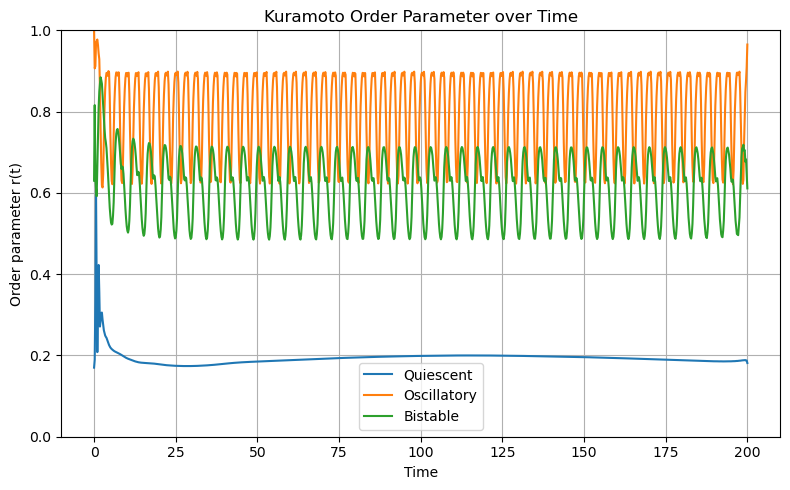

In [26]:
N, T = E_t1.shape

# 1) Compute analytic signal and instantaneous phase for each node
#    axis=1 means we do the transform over time for each row (node)
analytic_signal1 = hilbert(E_t1, axis=1)    # shape (N, T)
phase1 = np.angle(analytic_signal1)         # φ_j(t)

analytic_signal2 = hilbert(E_t2, axis=1)    # shape (N, T)
phase2 = np.angle(analytic_signal2)         # φ_j(t)

analytic_signal3 = hilbert(E_t3, axis=1)    # shape (N, T)
phase3 = np.angle(analytic_signal3)         # φ_j(t)

# 2) Compute the complex order parameter at each t
#    z(t) = (1/N) * sum_j exp(i φ_j(t))
z1 = np.mean(np.exp(1j * phase1), axis=0)   # shape (T,)
z2 = np.mean(np.exp(1j * phase2), axis=0)   # shape (T,)
z3 = np.mean(np.exp(1j * phase3), axis=0)   # shape (T,)

# 3) Extract magnitude r(t) and mean phase ψ(t)
r1 = np.abs(z1)                             # synchrony measure ∈ [0,1]
psi1 = np.angle(z1)                         # average phase

r2 = np.abs(z2)                             # synchrony measure ∈ [0,1]
psi2 = np.angle(z2)                         # average phase

r3 = np.abs(z3)                             # synchrony measure ∈ [0,1]
psi3 = np.angle(z3)                         # average phase

# 4) Plot r(t)
plt.figure(figsize=(8,5))
plt.plot(t_eval, r1, label='Quiescent')
plt.plot(t_eval, r2, label='Oscillatory')
plt.plot(t_eval, r3, label='Bistable')
plt.xlabel('Time')
plt.ylabel('Order parameter r(t)')
plt.title('Kuramoto Order Parameter over Time')
plt.ylim(0,1)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

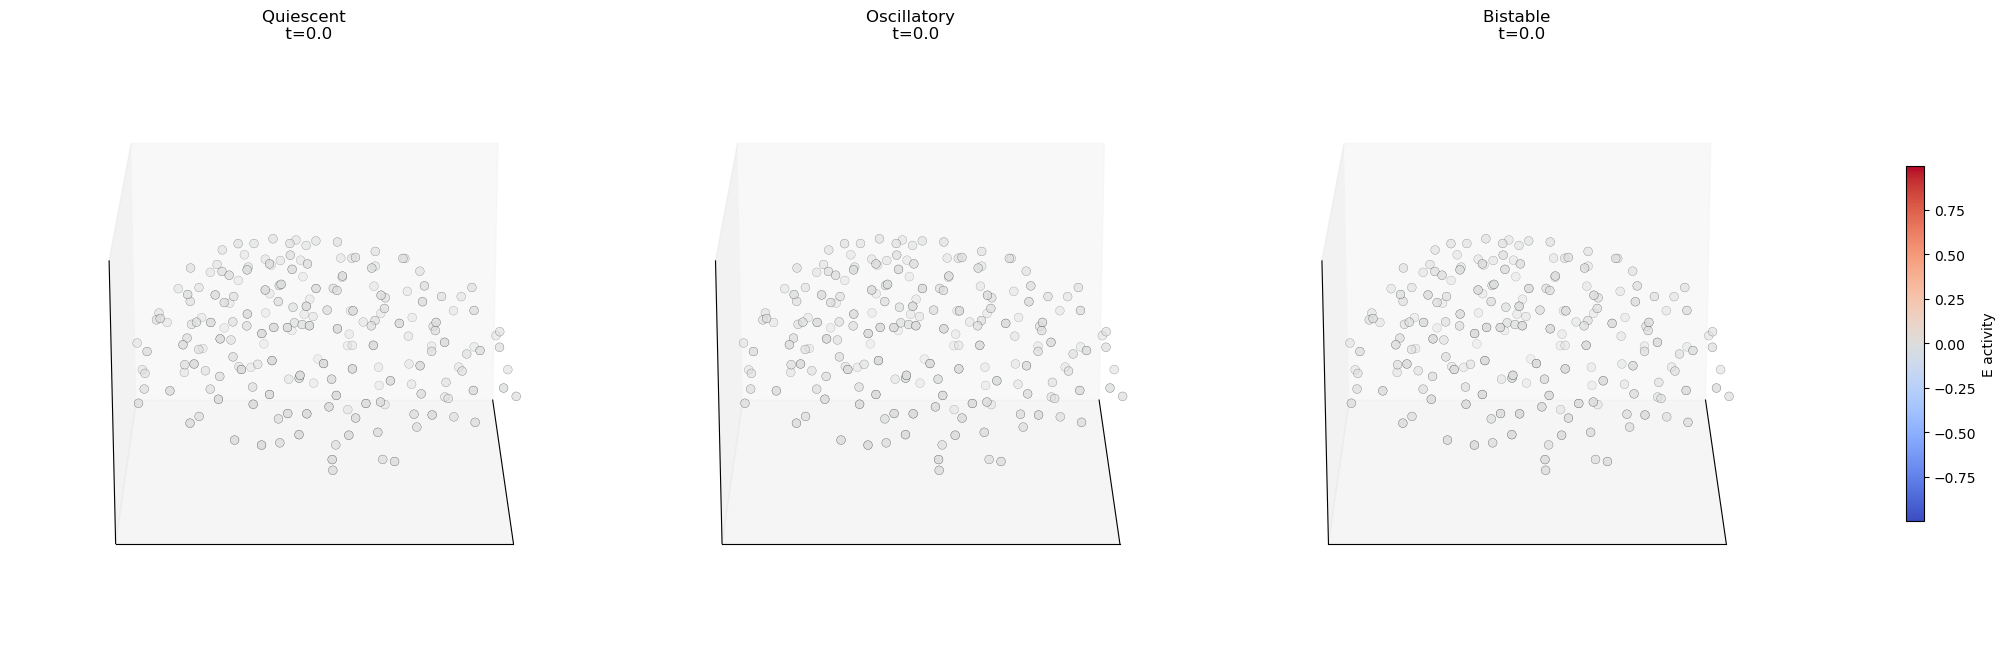

In [27]:
# Shared color limits
vmin = min(E_t1.min(), E_t2.min(), E_t3.min())
vmax = max(E_t1.max(), E_t2.max(), E_t3.max())

# ───── set up figure with 3 subplots ─────
fig, axes = plt.subplots(1, 3, figsize=(20,8),
                         subplot_kw={'projection': '3d'}, layout='compressed')

scats = []
for ax, E_t, title in zip(axes,
                          (E_t1, E_t2, E_t3),
                          ('Quiescent', 'Oscillatory', 'Bistable')):
    scat = ax.scatter(
        pos[:,0], pos[:,1], pos[:,2],
        c=E_t[:,0],
        cmap='coolwarm', vmin=vmin, vmax=vmax,
        s=40, edgecolor='k', lw=0.2
    )
    ax.set_title(f"{title}\n t=0.0")
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    ax.grid(True)
    # fix aspect ratio
    mr = (pos.max(axis=0) - pos.min(axis=0)).max() / 2
    mid = pos.mean(axis=0)
    ax.set_xlim(mid[0]-mr, mid[0]+mr)
    ax.set_ylim(mid[1]-mr, mid[1]+mr)
    ax.set_zlim(mid[2]-mr, mid[2]+mr)

    scats.append(scat)

# one shared colorbar on the right
plt.colorbar(scats[0], ax=axes, shrink=0.6, pad=0.05, label='E activity')

# ───── animation update ─────
def update(frame):
    angle = 180 * frame/(len(t_eval)-1)
    for scat, E_t, ax, title in zip(scats,
                                    (E_t1, E_t2, E_t3),
                                    axes,
                                    ('Quiescent', 'Oscillatory', 'Bistable')):
        scat.set_array(E_t[:, frame])
        ax.view_init(elev=20, azim=angle)
        ax.set_title(f"{title} \n t={t_eval[frame]:.1f}")
    return scats

anim = FuncAnimation(
    fig, update, frames=len(t_eval), interval=50, blit=True
)

plt.show()

writer = FFMpegWriter(
    fps=20,
    metadata=dict(artist='ZhuoZhuo Liu, Antonio Marín Carballo'),
    bitrate=1800,
    extra_args=['-vcodec', 'libx264']
)

# To save to MP4:
#anim.save('3d.mp4', dpi=150, writer=writer)
